In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler


In [2]:
files = ("site_2016.csv", "site_2017.csv", "site_2018.csv")
rainfall = pd.DataFrame()

for file in files:
    yearlyRainfall = pd.read_csv(file)
    rainfall = pd.concat([rainfall, yearlyRainfall], ignore_index=True, axis=0)
    
rainfall = rainfall.drop(columns="Unnamed: 0")
rainfall['datetime'] = pd.to_datetime(rainfall['datetime'])
rainfall['rainfall'] = rainfall['rainfall'].apply(lambda x: x.replace("[","").replace("]",""))
rainfall['rainfall'] = rainfall['rainfall'].astype(float)
rainfall.loc[315648,'datetime'] = rainfall.loc[315647,'datetime'] + timedelta(minutes=5)

rainfall.loc[315648,'rainfall'] = 0 

In [3]:
cav05 = pd.read_csv("CAV05_2013-2018.csv")
cav05['datetime'] = pd.to_datetime(cav05['datetime'])

In [4]:
cav05 = cav05[cav05["datetime"] >= datetime(2016,1,1,0,0,0)].copy().reset_index(drop=True)

In [5]:
cav05['datetimeDiff'] = ""

In [6]:

cav05

,datetime,water_level,datetimeDiff
0,2016-01-01 00:00:00,77.087,
1,2016-01-01 00:30:00,77.096,
2,2016-01-01 01:00:00,77.088,
3,2016-01-01 01:30:00,77.100,
4,2016-01-01 02:00:00,77.092,
...,...,...,...
52622,2018-12-31 21:30:00,77.063,
52623,2018-12-31 22:00:00,77.074,
52624,2018-12-31 22:30:00,77.067,
52625,2018-12-31 23:00:00,77.068,


In [7]:
for ind, dt in enumerate(cav05["datetime"]):
    if ind >= 1:
        cav05.loc[ind,'datetimeDiff'] = cav05.loc[ind,'datetime'] - cav05.loc[ind-1,'datetime']

In [8]:
cav05

,datetime,water_level,datetimeDiff
0,2016-01-01 00:00:00,77.087,
1,2016-01-01 00:30:00,77.096,0 days 00:30:00
2,2016-01-01 01:00:00,77.088,0 days 00:30:00
3,2016-01-01 01:30:00,77.100,0 days 00:30:00
4,2016-01-01 02:00:00,77.092,0 days 00:30:00
...,...,...,...
52622,2018-12-31 21:30:00,77.063,0 days 00:30:00
52623,2018-12-31 22:00:00,77.074,0 days 00:30:00
52624,2018-12-31 22:30:00,77.067,0 days 00:30:00
52625,2018-12-31 23:00:00,77.068,0 days 00:30:00


In [9]:
## Check any extra record within 30min interval 
## e.g. 10:22 in (10:00, 10:22, 10:30) shall be removed.
counter = 0
indList = []
for ind, dt in enumerate(cav05["datetimeDiff"]):
    if ind>=1:
        if (cav05.loc[ind, "datetimeDiff"] != timedelta(minutes=30) 
        and cav05.loc[ind, "datetimeDiff"] + cav05.loc[ind+1, "datetimeDiff"] == timedelta(minutes=30) ):
            print (cav05.loc[ind-1,'datetime'] , cav05.loc[ind,'datetime'], cav05.loc[ind+1,'datetime'])
            counter += 1
            indList.append(ind)
print(f"counter={counter}")



2016-01-12 10:00:00 2016-01-12 10:20:00 2016-01-12 10:30:00
2016-02-12 10:00:00 2016-02-12 10:18:00 2016-02-12 10:30:00
2016-04-15 11:00:00 2016-04-15 11:07:00 2016-04-15 11:30:00
2016-05-11 11:00:00 2016-05-11 11:13:00 2016-05-11 11:30:00
2016-06-16 10:00:00 2016-06-16 10:08:00 2016-06-16 10:30:00
2016-07-11 16:30:00 2016-07-11 16:38:00 2016-07-11 17:00:00
2016-08-10 15:00:00 2016-08-10 15:22:00 2016-08-10 15:30:00
2016-09-24 13:30:00 2016-09-24 13:34:00 2016-09-24 14:00:00
2016-10-11 10:00:00 2016-10-11 10:15:00 2016-10-11 10:30:00
2016-11-11 10:00:00 2016-11-11 10:12:00 2016-11-11 10:30:00
2016-12-13 10:00:00 2016-12-13 10:14:00 2016-12-13 10:30:00
2017-01-11 10:00:00 2017-01-11 10:08:00 2017-01-11 10:30:00
2017-02-14 10:00:00 2017-02-14 10:06:00 2017-02-14 10:30:00
2017-05-11 09:30:00 2017-05-11 09:38:00 2017-05-11 10:00:00
2017-08-14 10:00:00 2017-08-14 10:07:00 2017-08-14 10:30:00
2017-11-15 10:30:00 2017-11-15 10:41:00 2017-11-15 11:00:00
2018-02-10 09:30:00 2018-02-10 09:46:00 

In [10]:
## Delete any extra record within 30min interval 
cav05 = cav05.drop(indList).reset_index(drop=True)


In [11]:
## Check for any missing data (i.e. any data interval larger than 30min)
for ind, dt in enumerate(cav05["datetime"]):
    if ind >= 1:
        cav05.loc[ind,'datetimeDiff'] = cav05.loc[ind,'datetime'] - cav05.loc[ind-1,'datetime']

indList = []
for ind, dt in enumerate(cav05["datetimeDiff"]):
    if ind>=1:
        if (cav05.loc[ind, "datetimeDiff"] != timedelta(minutes=30) 
        ):
            print (cav05.loc[ind-1,'datetime'] , cav05.loc[ind,'datetime'], cav05.loc[ind+1,'datetime'])
            indList.append(ind)

            

2016-03-11 09:30:00 2016-03-11 10:54:00 2016-03-11 11:00:00
2016-03-11 10:54:00 2016-03-11 11:00:00 2016-03-11 11:30:00


In [12]:
indList

[3380, 3381]

In [13]:
cav05.loc[3376:3382]

idx_pos = 3380

cav05.loc[idx_pos,'datetime'] = cav05.loc[idx_pos+1,'datetime'] - timedelta(minutes=30)
new_row = pd.DataFrame({'datetime': [cav05.loc[idx_pos-1,'datetime']+timedelta(minutes=30)], 
                        'water_level': [(cav05.loc[idx_pos-1,'water_level'] + cav05.loc[idx_pos,'water_level'])/2 ],
                        'datetimeDiff': [timedelta(minutes=30)]
                       })


cav05_clean = pd.concat([cav05.iloc[:idx_pos], new_row, cav05.iloc[idx_pos:]]).reset_index(drop=True)

In [14]:
## calculate time difference and check any missing or extra data again
for ind, dt in enumerate(cav05_clean["datetime"]):
    if ind >= 1:
        cav05_clean.loc[ind,'datetimeDiff'] = cav05_clean.loc[ind,'datetime'] - cav05_clean.loc[ind-1,'datetime']
        
for ind, dt in enumerate(cav05["datetimeDiff"]):
    if ind>=1:
        if (cav05_clean.loc[ind, "datetimeDiff"] != timedelta(minutes=30) 
        ):
            print (cav05_clean.loc[ind-1,'datetime'] , cav05_clean.loc[ind,'datetime'], cav05_clean.loc[ind+1,'datetime'])

In [15]:
cav05_clean = cav05_clean.drop(columns = 'datetimeDiff')


In [16]:
cav05_clean

,datetime,water_level
0,2016-01-01 00:00:00,77.087
1,2016-01-01 00:30:00,77.096
2,2016-01-01 01:00:00,77.088
3,2016-01-01 01:30:00,77.100
4,2016-01-01 02:00:00,77.092
...,...,...
52603,2018-12-31 21:30:00,77.063
52604,2018-12-31 22:00:00,77.074
52605,2018-12-31 22:30:00,77.067
52606,2018-12-31 23:00:00,77.068


In [17]:
rainfall

,datetime,rainfall
0,2016-01-01 00:00:00,0.0
1,2016-01-01 00:05:00,0.0
2,2016-01-01 00:10:00,0.0
3,2016-01-01 00:15:00,0.0
4,2016-01-01 00:20:00,0.0
...,...,...
315644,2018-12-31 23:40:00,0.0
315645,2018-12-31 23:45:00,0.0
315646,2018-12-31 23:50:00,0.0
315647,2018-12-31 23:55:00,0.0


In [18]:
rainfall_30min = pd.DataFrame(columns = ['datetime','rainfall'])
for i in range(rainfall.shape[0]//6):
    rainfall_sum = rainfall['rainfall'][6*i+1:6*(i+1)+1].sum()
    rainfall_30min.loc[i,'datetime'] = rainfall['datetime'][6*(i+1)]
    rainfall_30min.loc[i,'rainfall'] = rainfall_sum
    

In [19]:
rainfall_30min['datetime'] = rainfall_30min['datetime'].astype("datetime64[ns]")

In [20]:
data = rainfall_30min.join(cav05_clean.set_index('datetime'), on='datetime', how='inner')

In [21]:
data

,datetime,rainfall,water_level
0,2016-01-01 00:30:00,0.0,77.096
1,2016-01-01 01:00:00,0.0,77.088
2,2016-01-01 01:30:00,0.0,77.100
3,2016-01-01 02:00:00,0.0,77.092
4,2016-01-01 02:30:00,0.0,77.095
...,...,...,...
52602,2018-12-31 21:30:00,0.0,77.063
52603,2018-12-31 22:00:00,0.0,77.074
52604,2018-12-31 22:30:00,0.0,77.067
52605,2018-12-31 23:00:00,0.0,77.068


In [23]:
for i in range(1, data.shape[0]):
    data.loc[i,'water_level_delta'] = data.loc[i,'water_level'] - data.loc[i-1,'water_level']

for i in range(5, data.shape[0]):
    data.loc[i,'ante_3hr_rainfall'] = data.loc[i-5:i,'rainfall'].sum()

for i in range(11, data.shape[0]):
    data.loc[i,'ante_6hr_rainfall'] = data.loc[i-11:i,'rainfall'].sum()

for i in range(23, data.shape[0]):
    data.loc[i,'ante_12hr_rainfall'] = data.loc[i-23:i,'rainfall'].sum()



In [24]:
for i in range(0, data.shape[0]):
    data.loc[i,'day_cos'] = np.cos((data.loc[i, 'datetime'].hour + data.loc[i, 'datetime'].minute/60) / 24 * 2 * np.pi)
    data.loc[i,'day_sin'] = np.sin((data.loc[i, 'datetime'].hour + data.loc[i, 'datetime'].minute/60) / 24 * 2 * np.pi)

    if data.loc[i, 'datetime'].year % 4 == 0:
        data.loc[i,'year_cos'] = np.cos(data.loc[i, 'datetime'].dayofyear/ 366 * 2 * np.pi)
        data.loc[i,'year_sin'] = np.sin(data.loc[i, 'datetime'].dayofyear/ 366 * 2 * np.pi)
    else:
        data.loc[i,'year_cos'] = np.cos(data.loc[i, 'datetime'].dayofyear/ 365 * 2 * np.pi)
        data.loc[i,'year_sin'] = np.sin(data.loc[i, 'datetime'].dayofyear/ 365 * 2 * np.pi)

In [25]:
data = data.drop(data.index[0:23]).reset_index(drop=True)
data[20000:21900]

,datetime,rainfall,water_level,water_level_delta,ante_3hr_rainfall,ante_6hr_rainfall,ante_12hr_rainfall,day_cos,day_sin,year_cos,year_sin
20000,2017-02-21 04:00:00,0.0,77.082,0.002,0.000000,0.000000,0.000000,5.000000e-01,0.866025,0.625411,0.780296
20001,2017-02-21 04:30:00,0.0,77.071,-0.011,0.000000,0.000000,0.000000,3.826834e-01,0.923880,0.625411,0.780296
20002,2017-02-21 05:00:00,0.0,77.084,0.013,0.000000,0.000000,0.000000,2.588190e-01,0.965926,0.625411,0.780296
20003,2017-02-21 05:30:00,0.0,77.080,-0.004,0.000000,0.000000,0.000000,1.305262e-01,0.991445,0.625411,0.780296
20004,2017-02-21 06:00:00,0.234928,77.076,-0.004,0.234928,0.234928,0.234928,6.123234e-17,1.000000,0.625411,0.780296
...,...,...,...,...,...,...,...,...,...,...,...
21895,2017-04-01 15:30:00,0.0,77.087,0.009,0.000000,0.000000,0.000000,-6.087614e-01,-0.793353,0.004304,0.999991
21896,2017-04-01 16:00:00,0.0,77.083,-0.004,0.000000,0.000000,0.000000,-5.000000e-01,-0.866025,0.004304,0.999991
21897,2017-04-01 16:30:00,0.0,77.079,-0.004,0.000000,0.000000,0.000000,-3.826834e-01,-0.923880,0.004304,0.999991
21898,2017-04-01 17:00:00,0.0,77.083,0.004,0.000000,0.000000,0.000000,-2.588190e-01,-0.965926,0.004304,0.999991


In [26]:
scaler_delta = StandardScaler()
delta_scaled = scaler_delta.fit_transform(data[['water_level_delta']].to_numpy())

epsilon = 3
extreme_left = -delta_scaled.std()*epsilon
extreme_right = delta_scaled.std()*epsilon
data['extreme']=(np.logical_or(delta_scaled<=extreme_left, delta_scaled>=extreme_right)*1)

In [27]:
scaler_delta.inverse_transform(np.array([-3]).reshape(-1, 1))

array([[-0.08440689]])

In [28]:
data[data['extreme']==1]

,datetime,rainfall,water_level,water_level_delta,ante_3hr_rainfall,ante_6hr_rainfall,ante_12hr_rainfall,day_cos,day_sin,year_cos,year_sin,extreme
196,2016-01-05 14:00:00,274.876658,77.752,0.657,300.814401,302.658405,310.140182,-8.660254e-01,-0.500000,0.996318,0.085731,1
197,2016-01-05 14:30:00,143.755133,77.463,-0.289,444.569534,446.413538,453.895315,-7.933533e-01,-0.608761,0.996318,0.085731,1
198,2016-01-05 15:00:00,3.719228,77.246,-0.217,448.288762,449.727048,457.614543,-7.071068e-01,-0.707107,0.996318,0.085731,1
4938,2016-04-13 09:00:00,33.545557,77.880,0.090,502.361603,502.361603,507.725638,-7.071068e-01,0.707107,-0.212947,0.977064,1
4941,2016-04-13 10:30:00,52.065769,78.135,0.103,302.447101,616.987538,620.701973,-9.238795e-01,0.382683,-0.212947,0.977064,1
...,...,...,...,...,...,...,...,...,...,...,...,...
47489,2018-09-16 20:30:00,105.456613,80.019,0.266,299.401087,535.316226,1577.171297,6.087614e-01,-0.793353,-0.251190,-0.967938,1
47490,2018-09-16 21:00:00,28.830802,79.926,-0.093,272.473437,507.464435,1479.530524,7.071068e-01,-0.707107,-0.251190,-0.967938,1
47514,2018-09-17 09:00:00,0.0,79.484,-0.102,0.000000,3.968331,99.015709,-7.071068e-01,0.707107,-0.234491,-0.972118,1
48972,2018-10-17 18:00:00,3.192753,77.336,0.096,42.078221,42.078221,42.078221,-1.836970e-16,-1.000000,0.276097,-0.961130,1


Text(0, 0.5, 'Elevation (mPD)')

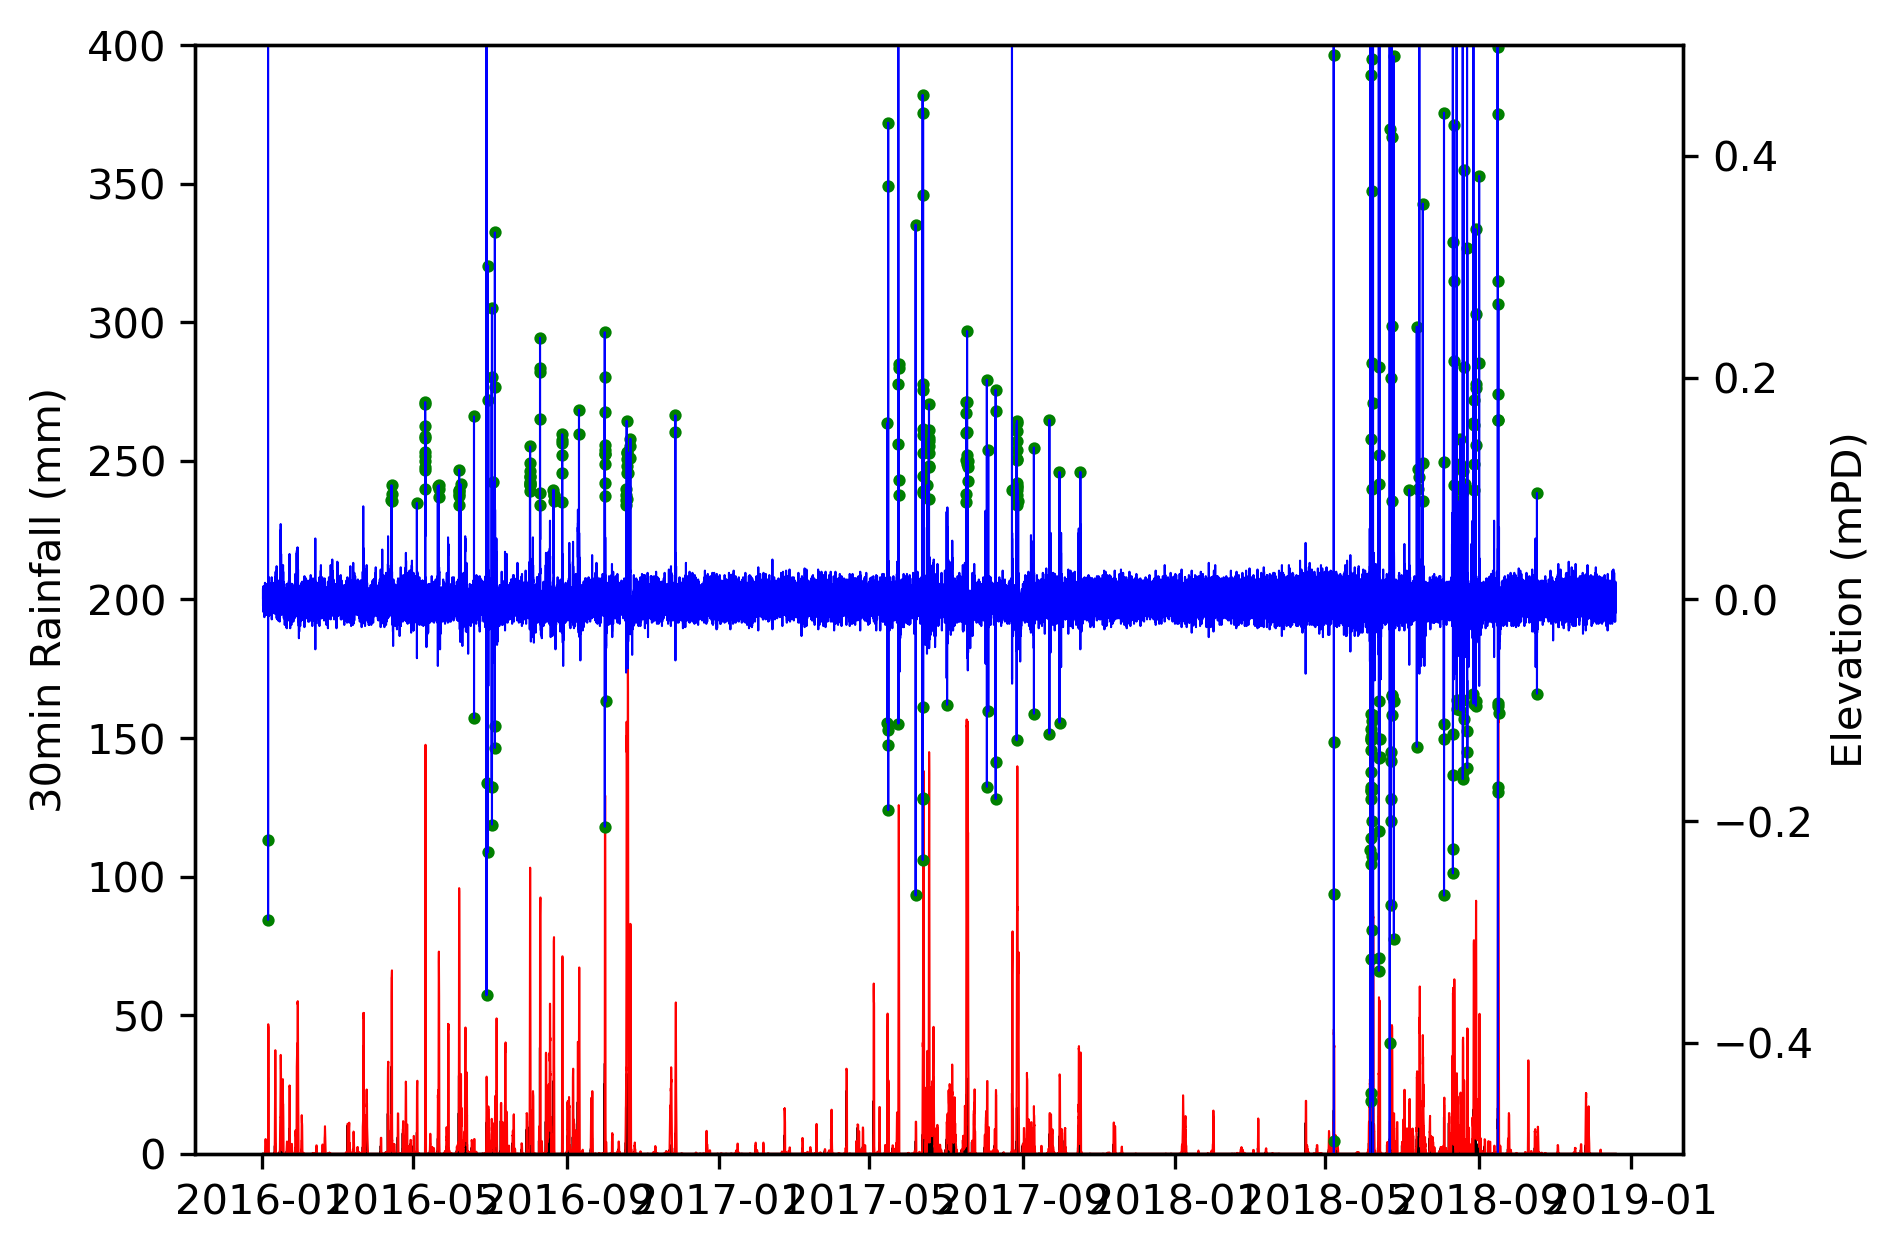

In [29]:
fig, ax1 = plt.subplots(dpi=300)
start, end = 0, 52000
# start, end = 35071,52607
ax1.plot(data['datetime'][start:end],data['rainfall'][start:end]/10, color='k', linewidth=0.5)
ax1.plot(data['datetime'][start:end],data['ante_12hr_rainfall'][start:end]/10, color='r', linewidth=0.5)

ax1.set_ylim(0,400)
ax1.set_ylabel("30min Rainfall (mm)")
ax2 = ax1.twinx()
ax2.plot(data['datetime'][start:end],data['water_level_delta'][start:end],color='b',linewidth=0.5)
ax2.scatter(data[data['extreme']==1]['datetime'], data[data['extreme']==1]['water_level_delta'], color='green',linewidth=0.5, s=6)
ax2.set_ylim(-0.5,0.5)
ax2.set_ylabel("Elevation (mPD)")

(array([0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 4.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        3.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 3.000e+00, 0.000e+00, 3.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 3.000e+0

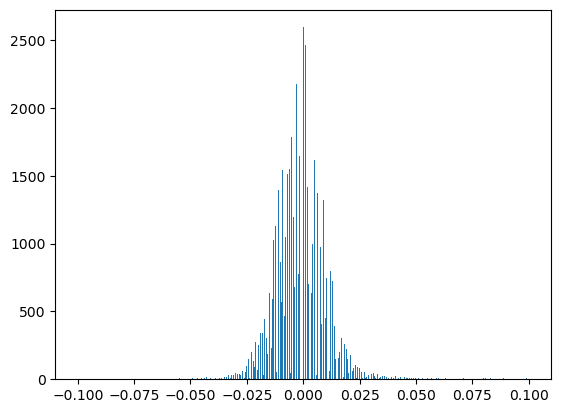

In [30]:
plt.hist(data['water_level_delta'],bins=500, range=(-0.1,0.1))

(array([0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 3.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        5.000e+00, 0.000e+00, 3.000e+00, 5.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 2.000e+00, 1.000e+00,
        3.000e+00, 4.000e+00, 3.000e+00, 1.000e+00, 2.000e+00, 1.000e+00,
        5.000e+00, 2.000e+00, 0.000e+00, 5.000e+00, 3.000e+00, 3.000e+00,
        3.000e+00, 6.000e+00, 0.000e+00, 4.000e+00, 1.000e+00, 2.000e+00,
        6.000e+00, 0.000e+00, 8.000e+00, 8.000e+00, 8.000e+00, 8.000e+00,
        9.000e+00, 1.000e+01, 1.300e+0

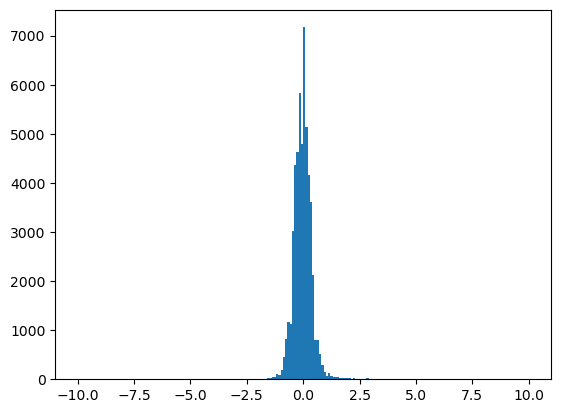

In [31]:
scaler_delta = StandardScaler()
delta_train_scaled = scaler_delta.fit_transform(data[['water_level_delta']].to_numpy())
plt.hist(delta_train_scaled,bins=200, range=(-10,10))

In [32]:
epsilon = 3
extreme_number = sum(1 for x in delta_train_scaled if float(x) >= delta_train_scaled.std()*epsilon) + sum(1 for x in delta_train_scaled if float(x) <= -delta_train_scaled.std()*epsilon)
percentage_extreme = extreme_number/len(delta_train_scaled)
print(extreme_number)
print(f'{percentage_extreme*100:.2f}%')

358
0.68%


In [46]:
def create_sequences(rainfall_data, level_data, level_delta_data, label_data, seq_length, step):
    X = []
    y_level_delta = []
    y_labels = []
    
    for i in range(len(rainfall_data) - seq_length - step):
        # Rainfall data for the full sequence
        rainfall_seq = rainfall_data[i:i + seq_length + step]
        
        # Level data padded to match rainfall sequence length
        level_seq = np.pad(level_data[i:i + seq_length], 
                           ((0, step), (0, 0)), 
                           mode='edge',
                          )
        
        # Combine rainfall and level data
        combined_seq = np.concatenate([rainfall_seq, level_seq], axis=1)
        
        X.append(combined_seq)
        y_level_delta.append(level_delta_data[(i + seq_length):(i + seq_length + step)])
        y_labels.append(label_data[(i + seq_length):(i + seq_length + step)])

    return np.array(X).astype(np.float32), np.squeeze(np.array(y_level_delta).astype(np.float32)), np.squeeze(np.array(y_labels).astype(np.float32))


In [25]:
'''
def create_sequences(rainfall_data, level_data, level_delta_data, seq_length, step):
    X_rainfall = []
    X_level = []
    y_level_delta = []
    for i in range(len(rainfall_data) - seq_length - step):
        X_rainfall.append(rainfall_data[i:i + seq_length + step])
        X_level.append(level_data[i:i + seq_length])
        y_level_delta.append(level_delta_data[(i + seq_length):(i + seq_length + step)])
    return np.array(X_rainfall).astype(np.float32), np.array(X_level).astype(np.float32), np.squeeze(np.array(y_level_delta).astype(np.float32))
'''

'\ndef create_sequences(rainfall_data, level_data, level_delta_data, seq_length, step):\n    X_rainfall = []\n    X_level = []\n    y_level_delta = []\n    for i in range(len(rainfall_data) - seq_length - step):\n        X_rainfall.append(rainfall_data[i:i + seq_length + step])\n        X_level.append(level_data[i:i + seq_length])\n        y_level_delta.append(level_delta_data[(i + seq_length):(i + seq_length + step)])\n    return np.array(X_rainfall).astype(np.float32), np.array(X_level).astype(np.float32), np.squeeze(np.array(y_level_delta).astype(np.float32))\n'

In [47]:
seq_length = 48
step = 6
input_rainfall_features = data[['rainfall','ante_3hr_rainfall','ante_6hr_rainfall','ante_12hr_rainfall']].to_numpy()
input_level_feature = data[['water_level']].to_numpy()
input_label = data[['extreme']].to_numpy()
target_feature = data[['water_level_delta']].to_numpy()

scaler_rainfall = StandardScaler()
scaler_level = StandardScaler()
scaler_delta = StandardScaler()



rainfall_train_scaled = scaler_rainfall.fit_transform(input_rainfall_features)
level_train_scaled = scaler_level.fit_transform(input_level_feature)
delta_train_scaled = scaler_delta.fit_transform(target_feature)

X_train_seq, y_delta_train_seq, y_labels_seq  = create_sequences(rainfall_train_scaled, level_train_scaled, delta_train_scaled, input_label, seq_length, step)



In [37]:
X_train_seq

array([[[-0.14264597, -0.19889174, -0.23258038, -0.28084484,
         -0.6984401 ],
        [-0.14264597, -0.19889174, -0.23258038, -0.28084484,
         -0.67883337],
        [-0.14264597, -0.19889174, -0.23258038, -0.28084484,
         -0.69059736],
        ...,
        [-0.14264597, -0.19889174, -0.23258038, -0.28084484,
         -0.7004007 ],
        [-0.14264597, -0.19889174, -0.23258038, -0.28084484,
         -0.7004007 ],
        [-0.14264597, -0.19889174, -0.23258038, -0.28084484,
         -0.7004007 ]],

       [[-0.14264597, -0.19889174, -0.23258038, -0.28084484,
         -0.67883337],
        [-0.14264597, -0.19889174, -0.23258038, -0.28084484,
         -0.69059736],
        [-0.14264597, -0.19889174, -0.23258038, -0.28084484,
         -0.67883337],
        ...,
        [-0.14264597, -0.19889174, -0.23258038, -0.28084484,
         -0.67687273],
        [-0.14264597, -0.19889174, -0.23258038, -0.28084484,
         -0.67687273],
        [-0.14264597, -0.19889174, -0.23258038, 

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras import backend as K


# 1. Define the input shape
input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])

# 2. Define the Attention layer (same as before)
class AttentionLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        et = tf.keras.backend.squeeze(tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b), axis=-1)
        at = tf.keras.backend.softmax(et)
        at = tf.keras.backend.expand_dims(at, axis=-1)
        output = x * at
        return tf.keras.backend.sum(output, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])


# 3. Build the model with increased complexity
def build_lstm_attention_model(input_shape, output_size):
    inputs = layers.Input(shape=input_shape)
    
    
    # LSTM layers with increased units
    x = layers.LSTM(1024, return_sequences=True, dropout=0)(inputs)
    # x = layers.BatchNormalization()(x)
    x = layers.LSTM(1024, return_sequences=True, dropout=0)(x)
    x = layers.LSTM(1024, return_sequences=True, dropout=0)(x)
    # x = layers.BatchNormalization()(x)
    x = layers.LSTM(1024, return_sequences=True, dropout=0)(x)
    x = layers.BatchNormalization()(x)
    
    # Attention layer
    attention_out = AttentionLayer()(x)
    
    # Dense layers with increased complexity
    x = layers.Dense(512, activation='relu')(attention_out)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dense(output_size, activation='linear')(x)
    
    # Create a new input for the labels
    label_input = layers.Input(shape=(step,))

    # Expand dimensions of outputs and label_input
    outputs_expanded = layers.Lambda(lambda x: tf.expand_dims(x, axis=-1))(outputs)
    label_input_expanded = layers.Lambda(lambda x: tf.expand_dims(x, axis=-1))(label_input)
    
    # Concatenate the model output with the label input
    combined_output = layers.Concatenate(axis=-1)([outputs_expanded, label_input_expanded])

    model = models.Model(inputs=[inputs, label_input], outputs=combined_output)
    return model

# Define custom loss function to calculate loss for extreme values only
def custom_masked_mse(y_true, y_pred):
    # Assuming y_true and y_pred have shape (batch_size, step, 2)
    # where the last dimension contains [actual_value, mask]
    mask = y_true[:, :, 1]
    y_true = y_true[:, :, 0]
    y_pred = y_pred[:, :, 0]  # Remove this line if y_pred doesn't have the extra dimension
    
    # Calculate squared error
    squared_error = tf.square(y_true - y_pred)
    
    # Apply mask
    masked_error = squared_error * mask
    
    # Calculate mean
    total_error = tf.reduce_sum(masked_error)
    total_count = tf.reduce_sum(mask)
    
    return total_error / (total_count + tf.keras.backend.epsilon())


# 4. Compile the model with a custom learning rate
output_size = step  
model = build_lstm_attention_model(input_shape, output_size)

initial_learning_rate = 1e-4
optimizer = Adam(learning_rate=initial_learning_rate)


model.compile(optimizer=optimizer, loss=custom_masked_mse)

# 5. Model summary
model.summary()

# 6. Train the model with increased epochs
y_true_combined = np.stack([y_delta_train_seq, y_labels_seq], axis=-1)

history = model.fit(
    [X_train_seq, y_labels_seq],  # Both X_train_seq and y_labels_seq as inputs
    y_true_combined,
    epochs=400,  # Increased number of epochs
    batch_size=64,  # Slightly larger batch size
    validation_split=0.33,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=30, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=10, min_lr=1e-6)
    ]
)

# 7. Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.yscale('log')  # Use log scale for better visualization
plt.show()


Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_32 (InputLayer)       [(None, 54, 5)]              0         []                            
                                                                                                  
 lstm_58 (LSTM)              (None, 54, 1024)             4218880   ['input_32[0][0]']            
                                                                                                  
 lstm_59 (LSTM)              (None, 54, 1024)             8392704   ['lstm_58[0][0]']             
                                                                                                  
 lstm_60 (LSTM)              (None, 54, 1024)             8392704   ['lstm_59[0][0]']             
                                                                                           

2024-08-08 12:34:06.803238: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-08 12:34:07.180607: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-08 12:34:07.251241: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-08 12:34:07.364788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-08 12:34:07.471049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-08 12:34:08.386471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-08 12:34:08.537190: I tensorflow/core/grappler/optimizers/cust

550/550 [==============================] - ETA: 0s - loss: 25.5190

2024-08-08 12:35:58.234249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-08 12:35:58.371254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-08 12:35:58.460831: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-08 12:35:58.527791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-08 12:35:58.614437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


550/550 [==============================] - 130s 229ms/step - loss: 25.5190 - val_loss: 20.8864 - lr: 1.0000e-04
Epoch 2/400
550/550 [==============================] - 125s 228ms/step - loss: 24.6750 - val_loss: 20.6047 - lr: 1.0000e-04
Epoch 3/400
550/550 [==============================] - 125s 227ms/step - loss: 25.1826 - val_loss: 20.2037 - lr: 1.0000e-04
Epoch 4/400
550/550 [==============================] - 125s 227ms/step - loss: 25.8194 - val_loss: 19.8190 - lr: 1.0000e-04
Epoch 5/400
550/550 [==============================] - 125s 227ms/step - loss: 23.2414 - val_loss: 21.2292 - lr: 1.0000e-04
Epoch 6/400
550/550 [==============================] - 125s 227ms/step - loss: 24.8951 - val_loss: 19.7367 - lr: 1.0000e-04
Epoch 7/400
550/550 [==============================] - 126s 230ms/step - loss: 23.6314 - val_loss: 21.1606 - lr: 1.0000e-04
Epoch 8/400
550/550 [==============================] - 125s 227ms/step - loss: 25.3657 - val_loss: 21.2702 - lr: 1.0000e-04
Epoch 9/400
550/550 

In [ ]:
'''
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Input, Concatenate, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.losses import MAPE
from tensorflow.keras import backend as K
# from tensorflow.keras.losses import Huber



def weighted_mse_loss(y_true, y_pred):
    # Assign higher weights to later steps
    weights = K.constant([1/21, 2/21, 3/21, 4/21, 5/21, 6/21])  # Adjust weights as needed
    squared_error = K.square(y_pred - y_true)
    weighted_squared_error = squared_error * weights
    return K.mean(weighted_squared_error, axis=-1)

# Define an increasing dropout schedule
class StepwiseDropoutCallback(Callback):
    def __init__(self, initial_rate=0.1, max_rate=0.5, step_size=0.05, epoch_step=20):
        super().__init__()
        self.initial_rate = initial_rate
        self.max_rate = max_rate
        self.step_size = step_size
        self.epoch_step = epoch_step

    def on_epoch_begin(self, epoch, logs=None):
        steps = epoch // self.epoch_step
        new_rate = min(self.initial_rate + steps * self.step_size, self.max_rate)
        
        for layer in self.model.layers:
            if isinstance(layer, Dropout):
                layer.rate = new_rate
        
        print(f"Epoch {epoch}: dropout rate set to {new_rate}")

# Create an instance of the callback
stepwise_dropout = StepwiseDropoutCallback(initial_rate=0.05, max_rate=0.5, step_size=0.025, epoch_step=50)



# Define Early Stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=50,         # Number of epochs with no improvement after which training will be stopped
    mode='min',          # In this case, we want to minimize the val_loss
    restore_best_weights=True,  # Restores model weights from the epoch with the best value of the monitored quantity
    verbose=1
)

# Define the model

combined_input = Input(shape=(seq_length + step, 5))



# Process level input
x1 = LSTM(32, activation='tanh', return_sequences=True)(combined_input)
# x1 = Dropout(0.1, name='dropout_1')(x1)
# x1 = LSTM(128, activation='tanh')(x1)

#Attention layer
output = Attention(32)(x1)

# Output layer
# output = Dense(32, activation='relu')(combined)
output = Dense(step)(out)
# output = Dense(step, activation='tanh')(combined)

# Create the model
model = Model(inputs=[combined_input], outputs=output)


# Compile the model
model.compile(optimizer=Adam(learning_rate=0.005), loss='logcosh')

# Train the model
history = model.fit([X_train_seq], y_level_train_seq, 
                    epochs=800, 
                    batch_size=128, 
                    shuffle = True,
                    validation_split=0.33,
                    callbacks=[early_stopping, stepwise_dropout],
                    # callbacks=[early_stopping],
                    verbose=1)

'''


In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


In [113]:
# Make predictions


train_predictions = model.predict([X_train_seq, y_labels_seq])[:, :, 0]


# Inverse transform the predictions
train_predictions = scaler_delta.inverse_transform(train_predictions)


y_train_actual = scaler_delta.inverse_transform(y_delta_train_seq)

# y_train_actual = scaler_delta.inverse_transform(y_delta_train_seq.reshape(-1, 1))

2024-08-08 10:58:53.451873: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-08 10:58:53.611600: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-08 10:58:53.910620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-08 10:58:53.996741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1642/1642 [==============================] - 55s 33ms/step


In [114]:
train_predictions = train_predictions * y_labels_seq
y_train_actual = y_train_actual * y_labels_seq

In [115]:
train_predictions_last_step = train_predictions[:,5].reshape((y_train_actual.shape[0],1))
y_train_actual_last_step = y_train_actual[:,5].reshape((y_train_actual.shape[0],1))

# train_predictions_last_step = train_predictions[:,step-1].reshape((y_train_actual.shape[0],1))
# y_train_actual_last_step = y_train_actual[:,step-1].reshape((y_train_actual.shape[0],1))

In [116]:
from sklearn.metrics import r2_score
train_r2 = r2_score(y_train_actual_last_step, train_predictions_last_step, multioutput='raw_values')
# naive_r2 = r2_score(y_train_actual, naive_predictions, multioutput='raw_values')
print(f"Train R2 scores: {train_r2}")
# print(f"Naive R2 scores: {naive_r2}")

Train R2 scores: [0.26367579]


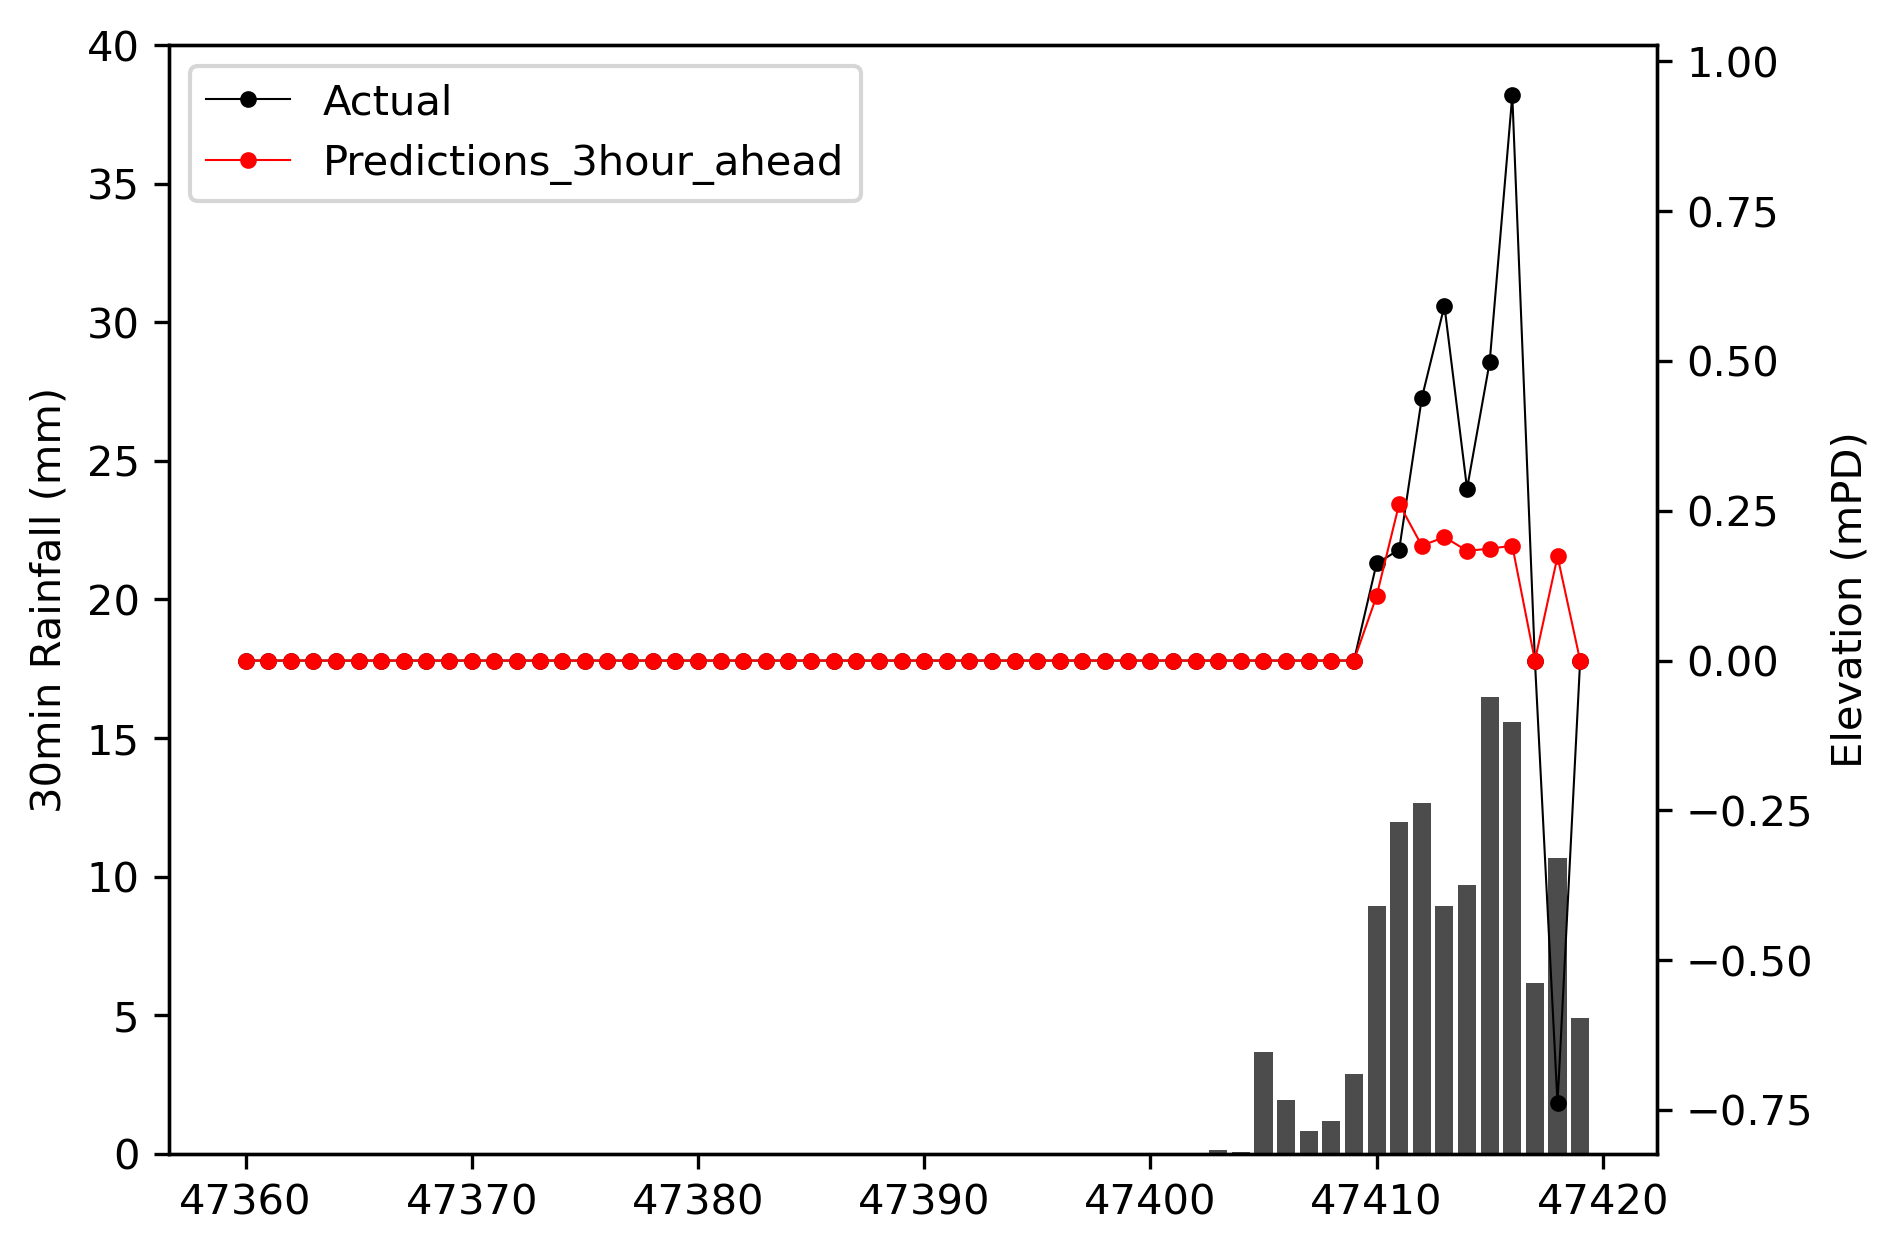

In [117]:
fig, ax1 = plt.subplots(dpi=300)
start, end = 47360, 47420

ax1.bar(range(len(y_train_actual_last_step))[start:end],input_rainfall_features[start+seq_length+step:end+seq_length+step,0]/10,color='k',linewidth=0.5, alpha=0.7)
ax1.set_ylim(0,40)
ax1.set_ylabel("30min Rainfall (mm)")

ax2 = ax1.twinx()
ax2.plot(range(len(y_train_actual_last_step))[start:end],y_train_actual_last_step[start:end],'-o', markersize=3, color='k',linewidth=0.5, label='Actual')
# ax2.plot(range(len(naive_predictions))[start:end],naive_predictions[start:end],'-o', markersize=3, color='grey',linewidth=0.3, alpha=0.2, label='Naive Forecast')
ax2.plot(range(len(train_predictions_last_step))[start:end],train_predictions_last_step[start:end],'-o', markersize=3, color='r',linewidth=0.5, label='Predictions_3hour_ahead')

# ax2.set_ylim(-3,2)
# ax2.set_ylim(76,82)
ax2.set_ylabel("Elevation (mPD)")

ax2.legend()
ax2.grid(axis = 'x')

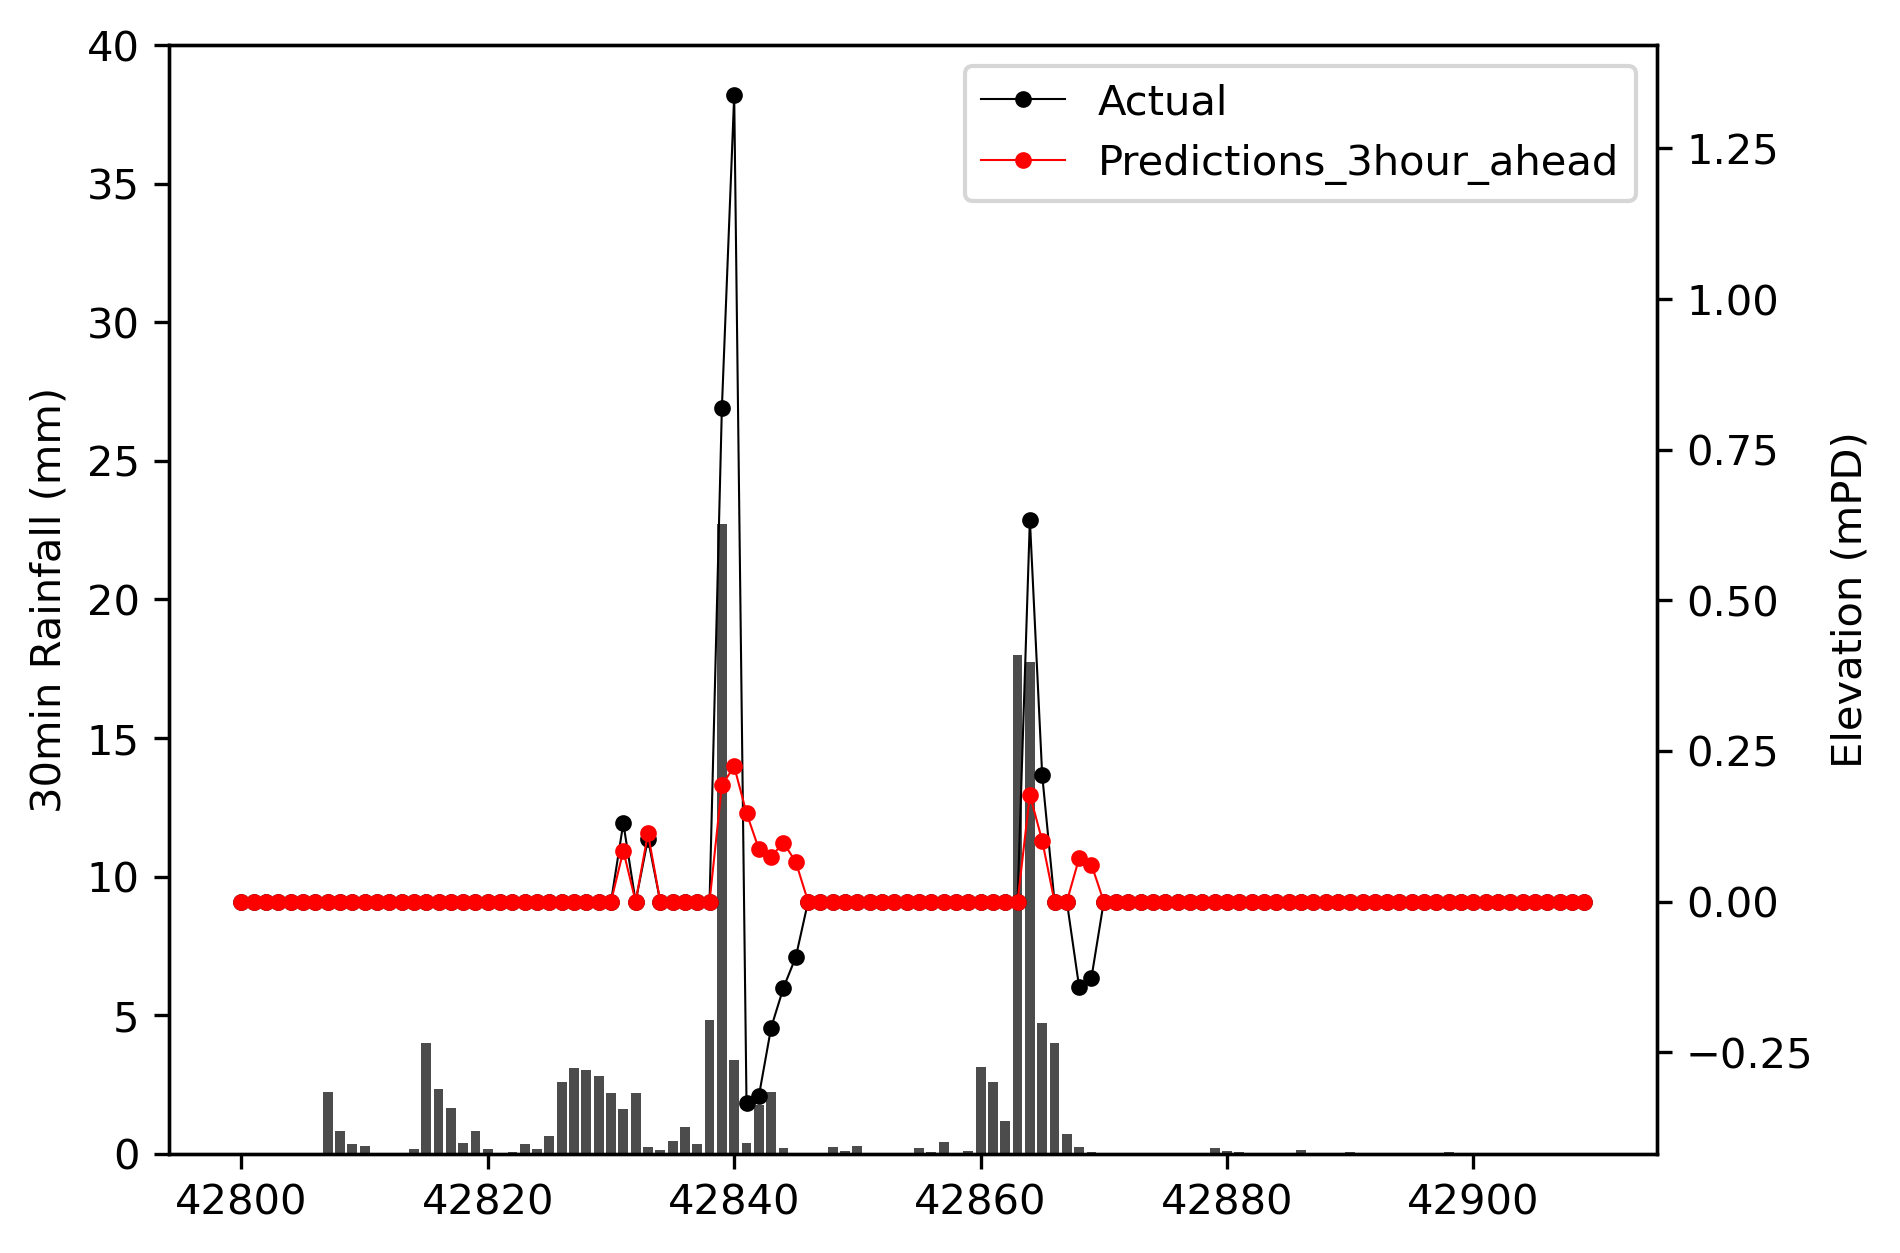

In [118]:
fig, ax1 = plt.subplots(dpi=300)
start, end = 42800, 42910


ax1.bar(range(len(y_train_actual_last_step))[start:end],input_rainfall_features[start+seq_length+step:end+seq_length+step,0]/10,color='k',linewidth=0.5, alpha=0.7)
ax1.set_ylim(0,40)
ax1.set_ylabel("30min Rainfall (mm)")

ax2 = ax1.twinx()
ax2.plot(range(len(y_train_actual_last_step))[start:end],y_train_actual_last_step[start:end],'-o', markersize=3, color='k',linewidth=0.5, label='Actual')
# ax2.plot(range(len(naive_predictions))[start:end],naive_predictions[start:end],'-o', markersize=3, color='grey',linewidth=0.3, alpha=0.2, label='Naive Forecast')
ax2.plot(range(len(train_predictions_last_step))[start:end],train_predictions_last_step[start:end],'-o', markersize=3, color='r',linewidth=0.5, label='Predictions_3hour_ahead')

# ax2.set_ylim(-3,2)
# ax2.set_ylim(76,82)
ax2.set_ylabel("Elevation (mPD)")

ax2.legend()
ax2.grid(axis = 'x')

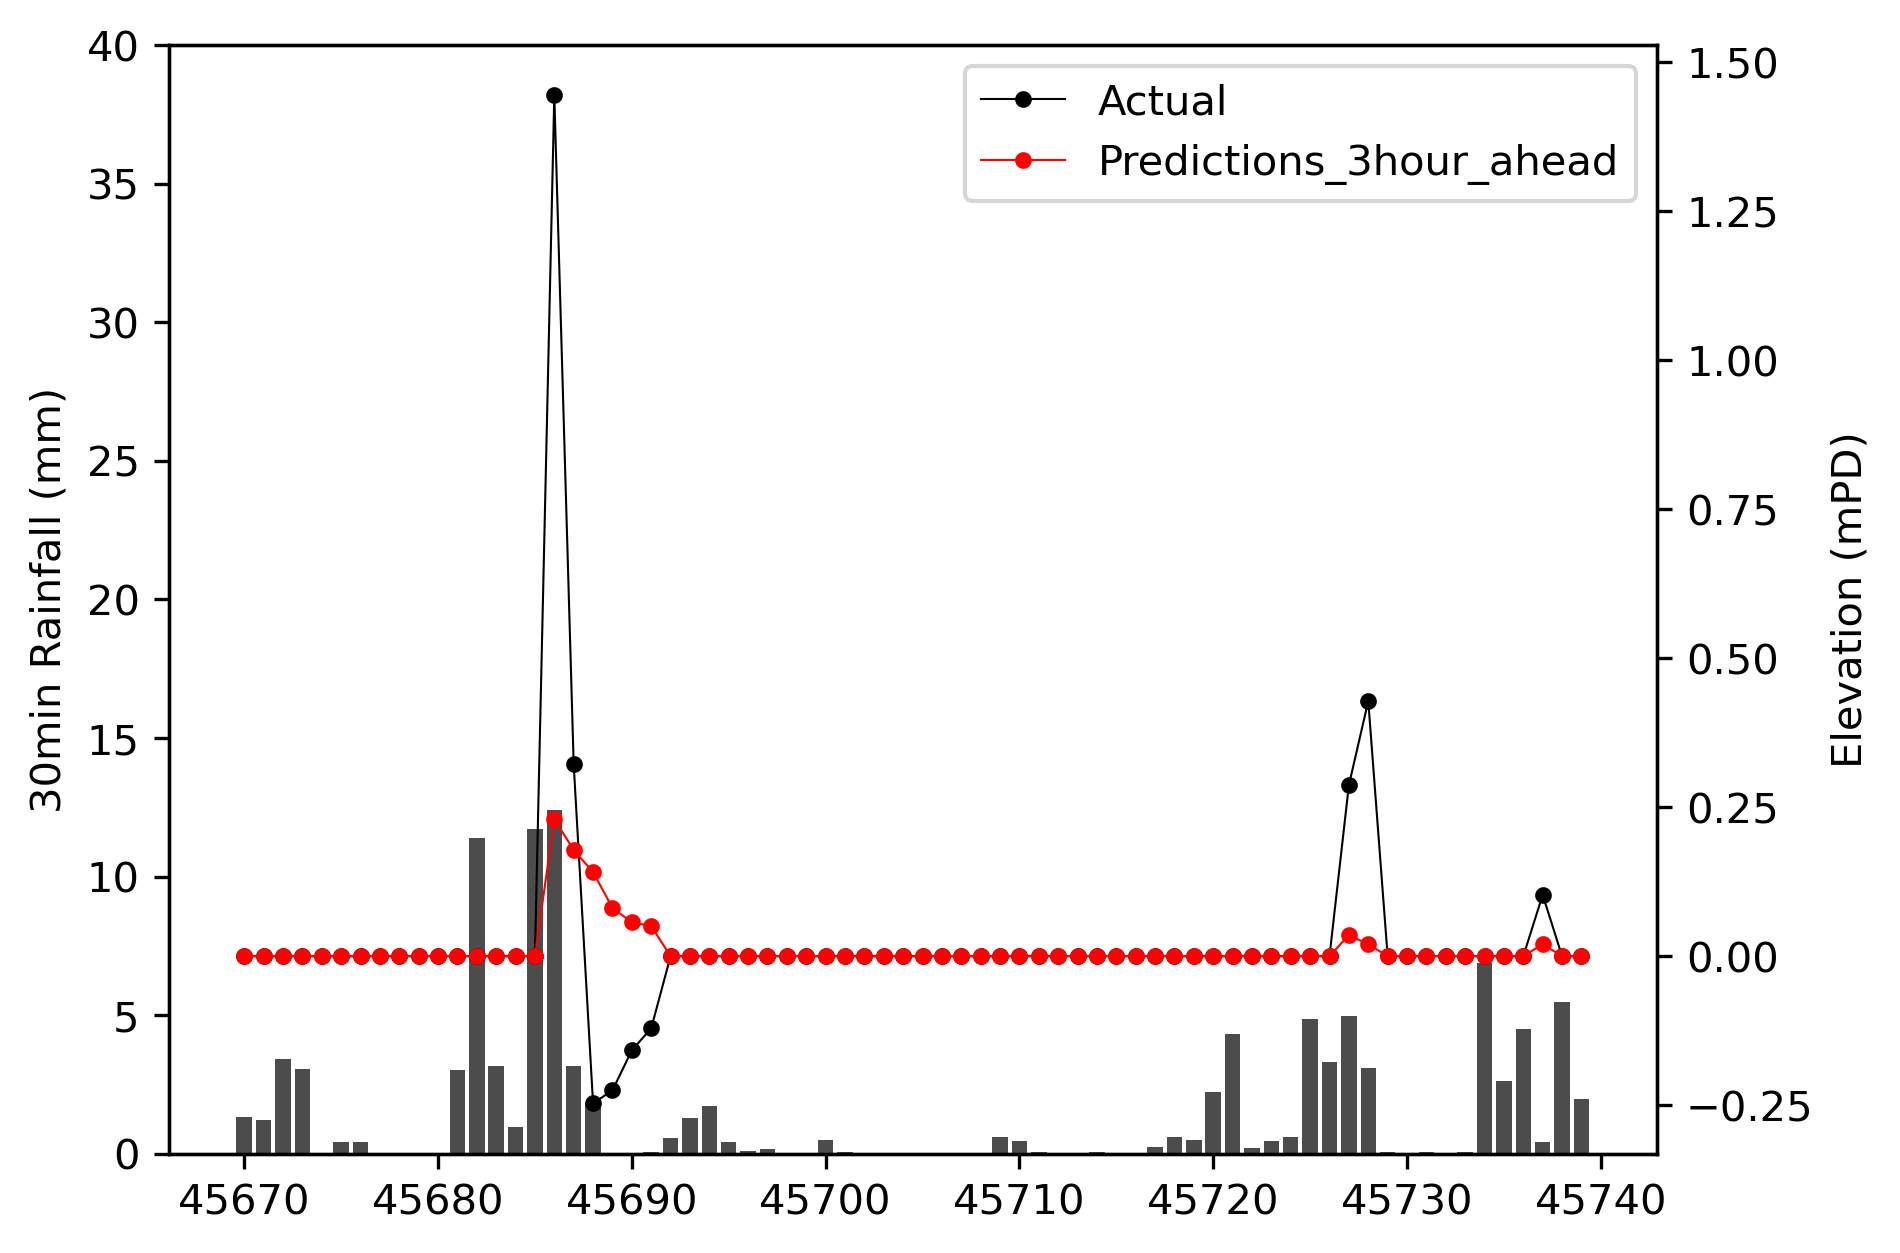

In [121]:
fig, ax1 = plt.subplots(dpi=300)
start, end = 45670, 45740


ax1.bar(range(len(y_train_actual_last_step))[start:end],input_rainfall_features[start+seq_length+step:end+seq_length+step,0]/10,color='k',linewidth=0.5, alpha=0.7)
ax1.set_ylim(0,40)
ax1.set_ylabel("30min Rainfall (mm)")

ax2 = ax1.twinx()
ax2.plot(range(len(y_train_actual_last_step))[start:end],y_train_actual_last_step[start:end],'-o', markersize=3, color='k',linewidth=0.5, label='Actual')
# ax2.plot(range(len(naive_predictions))[start:end],naive_predictions[start:end],'-o', markersize=3, color='grey',linewidth=0.3, alpha=0.2, label='Naive Forecast')
ax2.plot(range(len(train_predictions_last_step))[start:end],train_predictions_last_step[start:end],'-o', markersize=3, color='r',linewidth=0.5, label='Predictions_3hour_ahead')

# ax2.set_ylim(-3,2)
# ax2.set_ylim(76,82)
ax2.set_ylabel("Elevation (mPD)")

ax2.legend()
ax2.grid(axis = 'x')

In [120]:
# model.save("3hour_ahead_classification.keras")

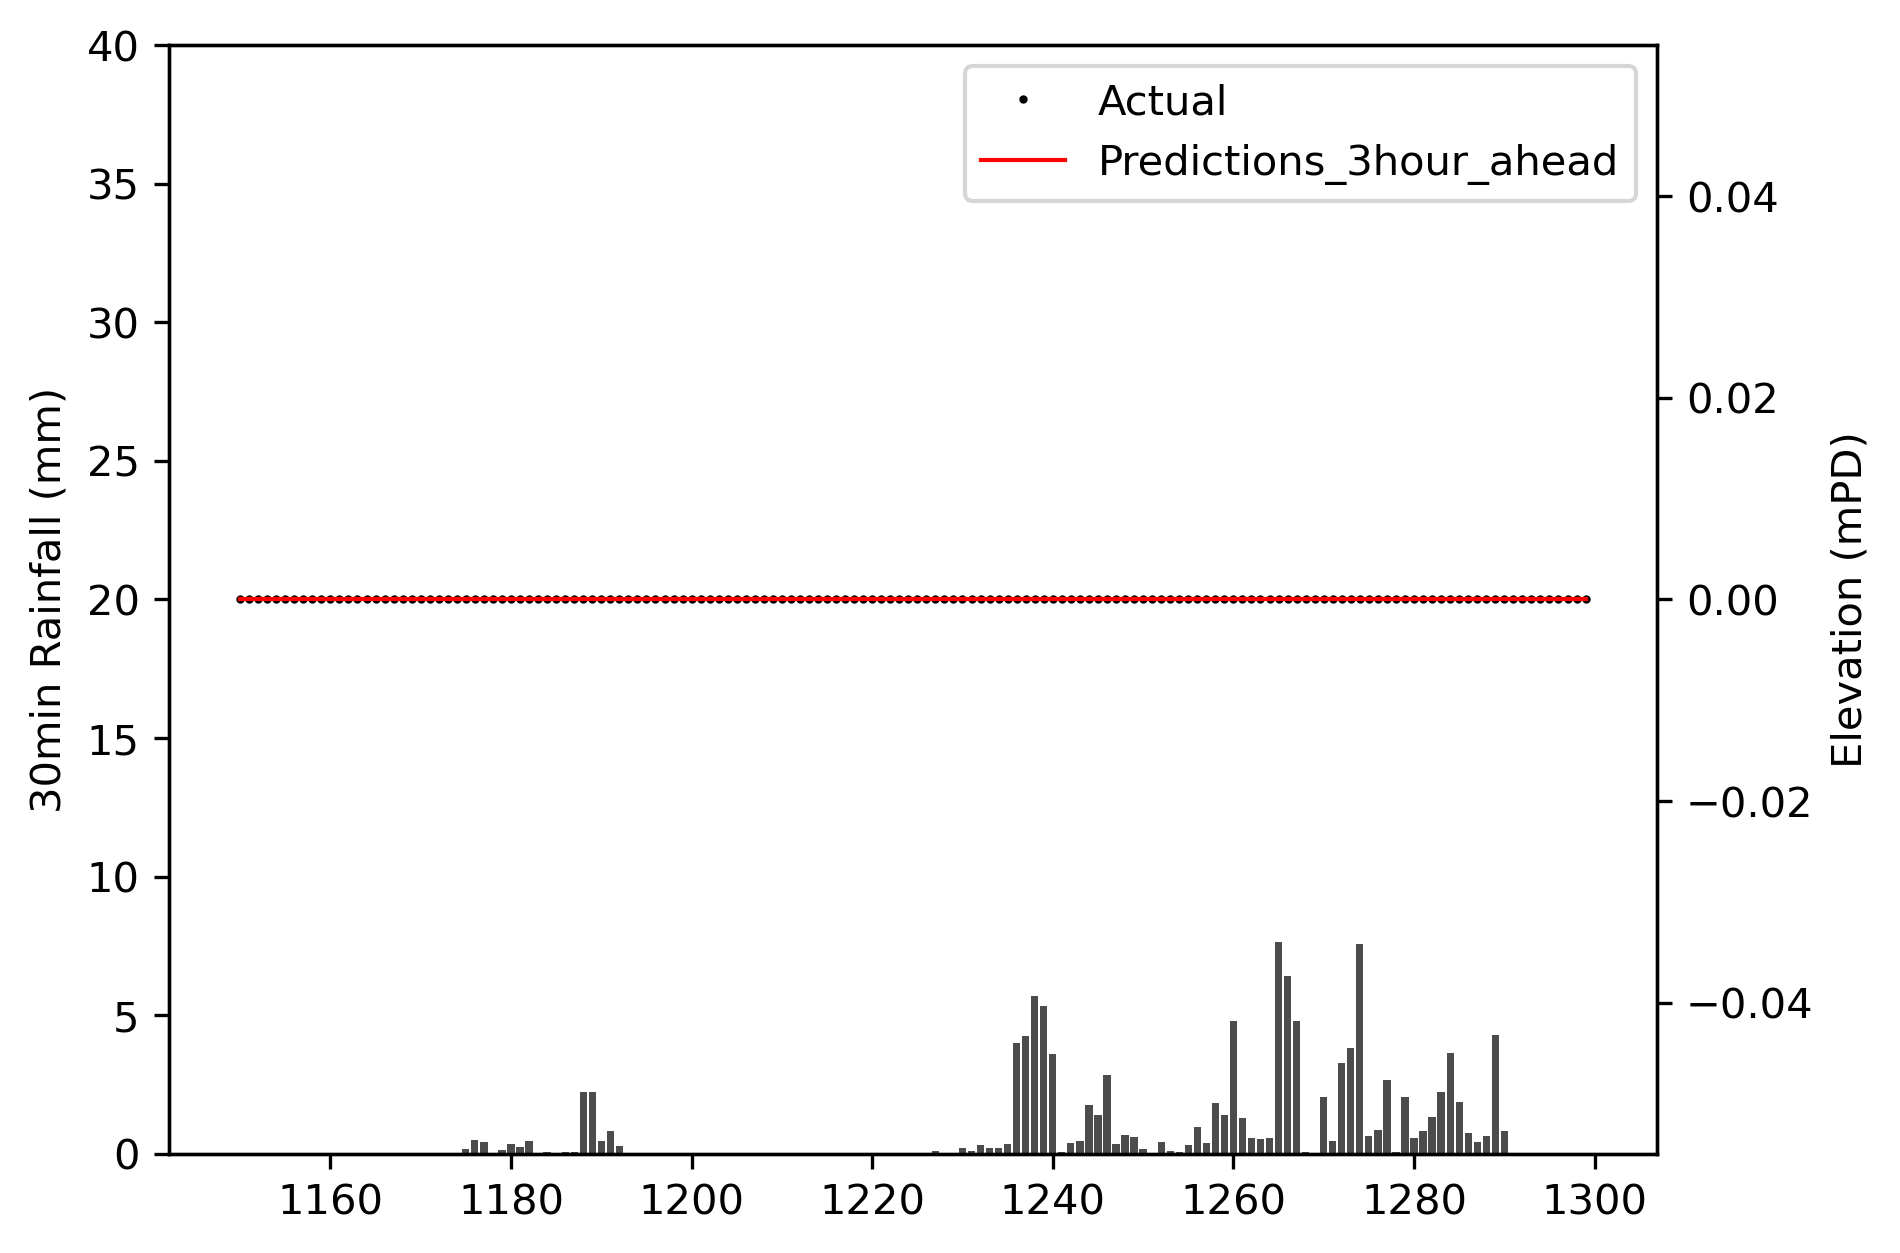

In [122]:
fig, ax1 = plt.subplots(dpi=300)
start, end = 1150, 1300


ax1.bar(range(len(y_train_actual_last_step))[start:end],input_rainfall_features[start+seq_length+step:end+seq_length+step,0]/10,color='k',linewidth=0.5, alpha=0.7)
ax1.set_ylim(0,40)
ax1.set_ylabel("30min Rainfall (mm)")

ax2 = ax1.twinx()
ax2.plot(range(len(y_train_actual_last_step))[start:end],y_train_actual_last_step[start:end],'o', markersize=1, color='k',linewidth=0.1, label='Actual')
# ax2.plot(range(len(naive_predictions))[start:end],naive_predictions[start:end],'-o', markersize=3, color='grey',linewidth=0.3, alpha=0.2, label='Naive Forecast')
ax2.plot(range(len(train_predictions_last_step))[start:end],train_predictions_last_step[start:end],'-', markersize=3, color='r',linewidth=1, label='Predictions_3hour_ahead')

# ax2.set_ylim(-3,2)
# ax2.set_ylim(76,82)
ax2.set_ylabel("Elevation (mPD)")

ax2.legend()
ax2.grid(axis = 'x')

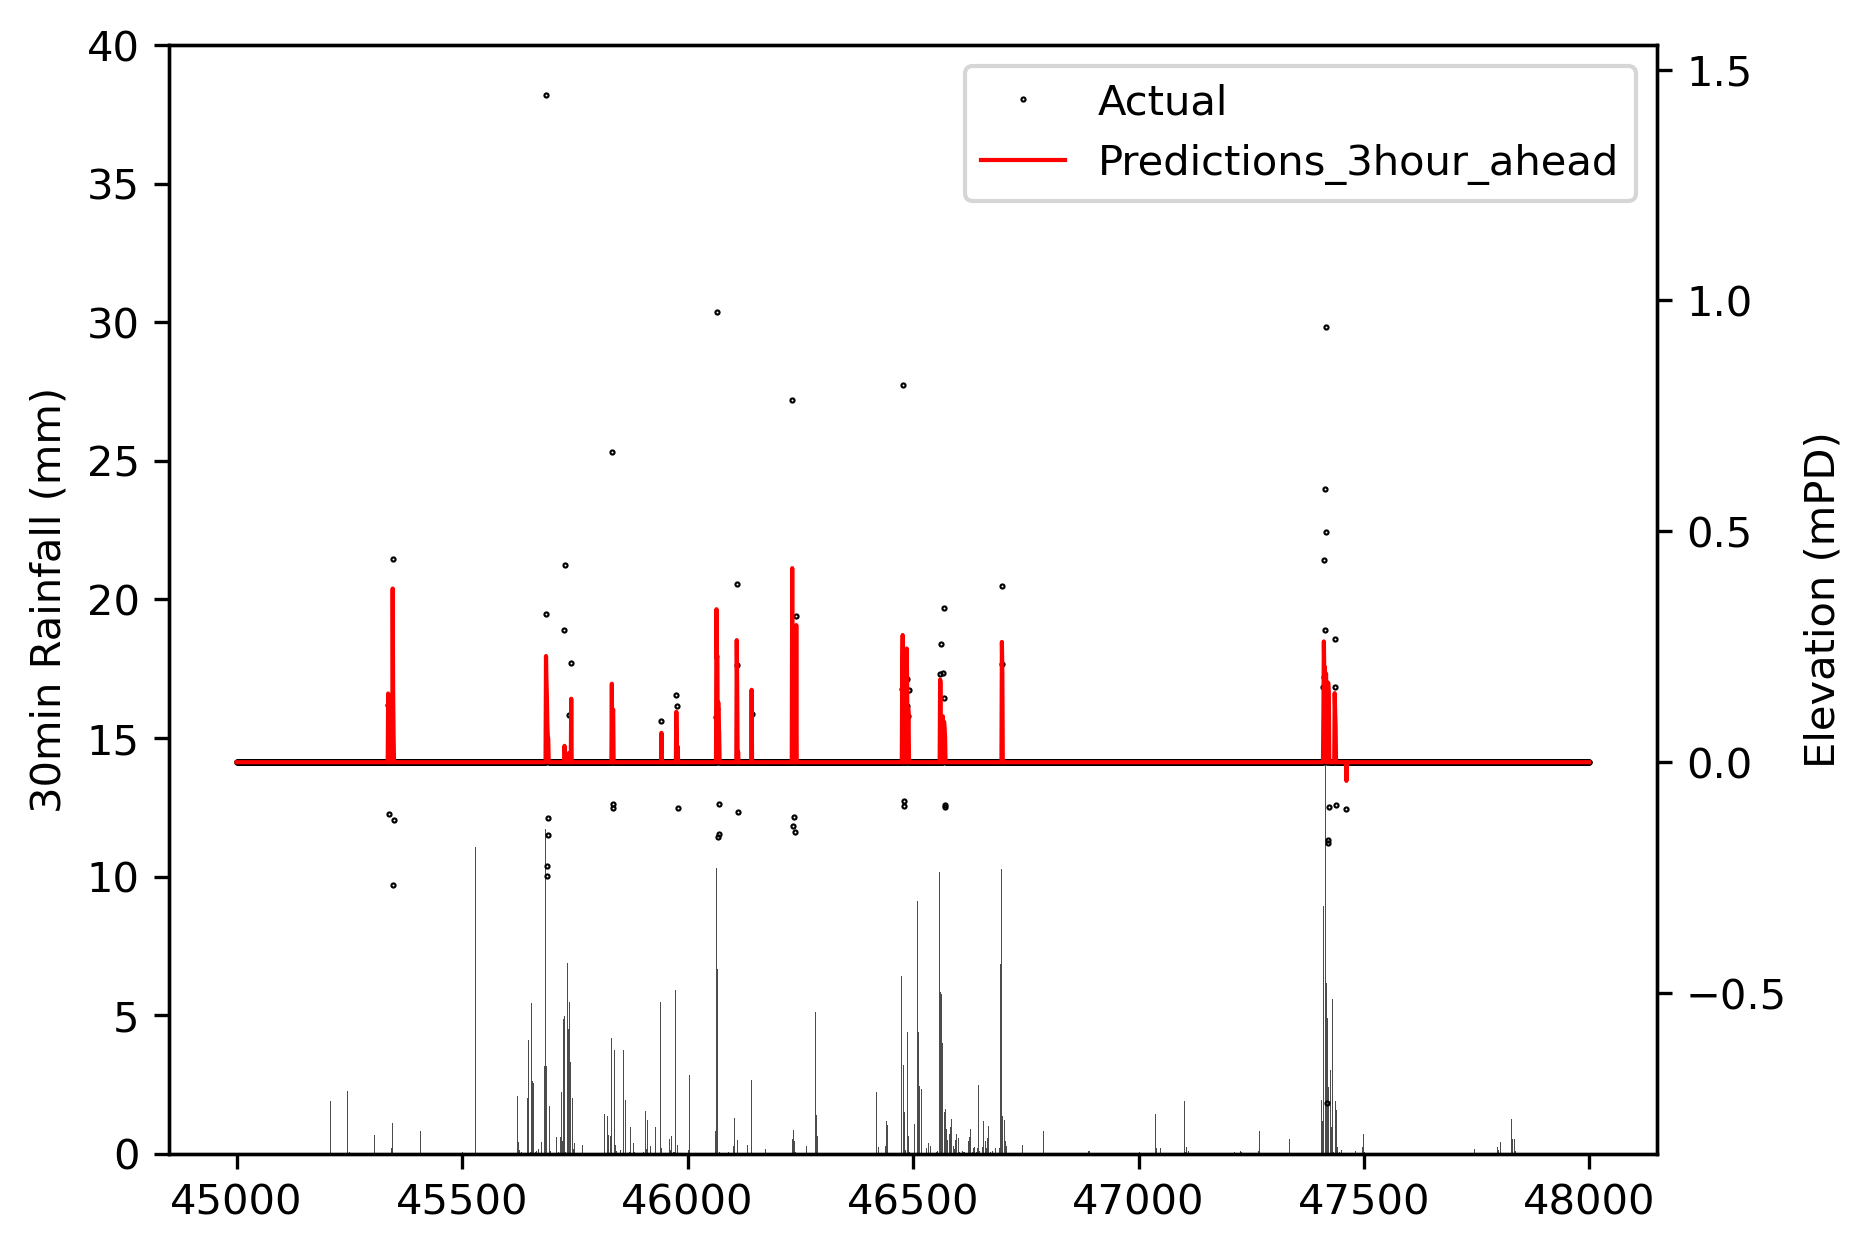

In [123]:
fig, ax1 = plt.subplots(dpi=300)
start, end = 45000, 48000


ax1.bar(range(len(y_train_actual_last_step))[start:end],input_rainfall_features[start+seq_length+step:end+seq_length+step,0]/10,color='k',linewidth=0.5, alpha=0.7)
ax1.set_ylim(0,40)
ax1.set_ylabel("30min Rainfall (mm)")

ax2 = ax1.twinx()
ax2.plot(range(len(y_train_actual_last_step))[start:end],y_train_actual_last_step[start:end],'.', markersize=1, color='k',linewidth=0.1, mfc='none', label='Actual')
# ax2.plot(range(len(naive_predictions))[start:end],naive_predictions[start:end],'-o', markersize=3, color='grey',linewidth=0.3, alpha=0.2, label='Naive Forecast')
ax2.plot(range(len(train_predictions_last_step))[start:end],train_predictions_last_step[start:end],'-', markersize=3, color='r',linewidth=1, label='Predictions_3hour_ahead')

# ax2.set_ylim(-3,2)
# ax2.set_ylim(76,82)
ax2.set_ylabel("Elevation (mPD)")

ax2.legend()
ax2.grid(axis = 'x')

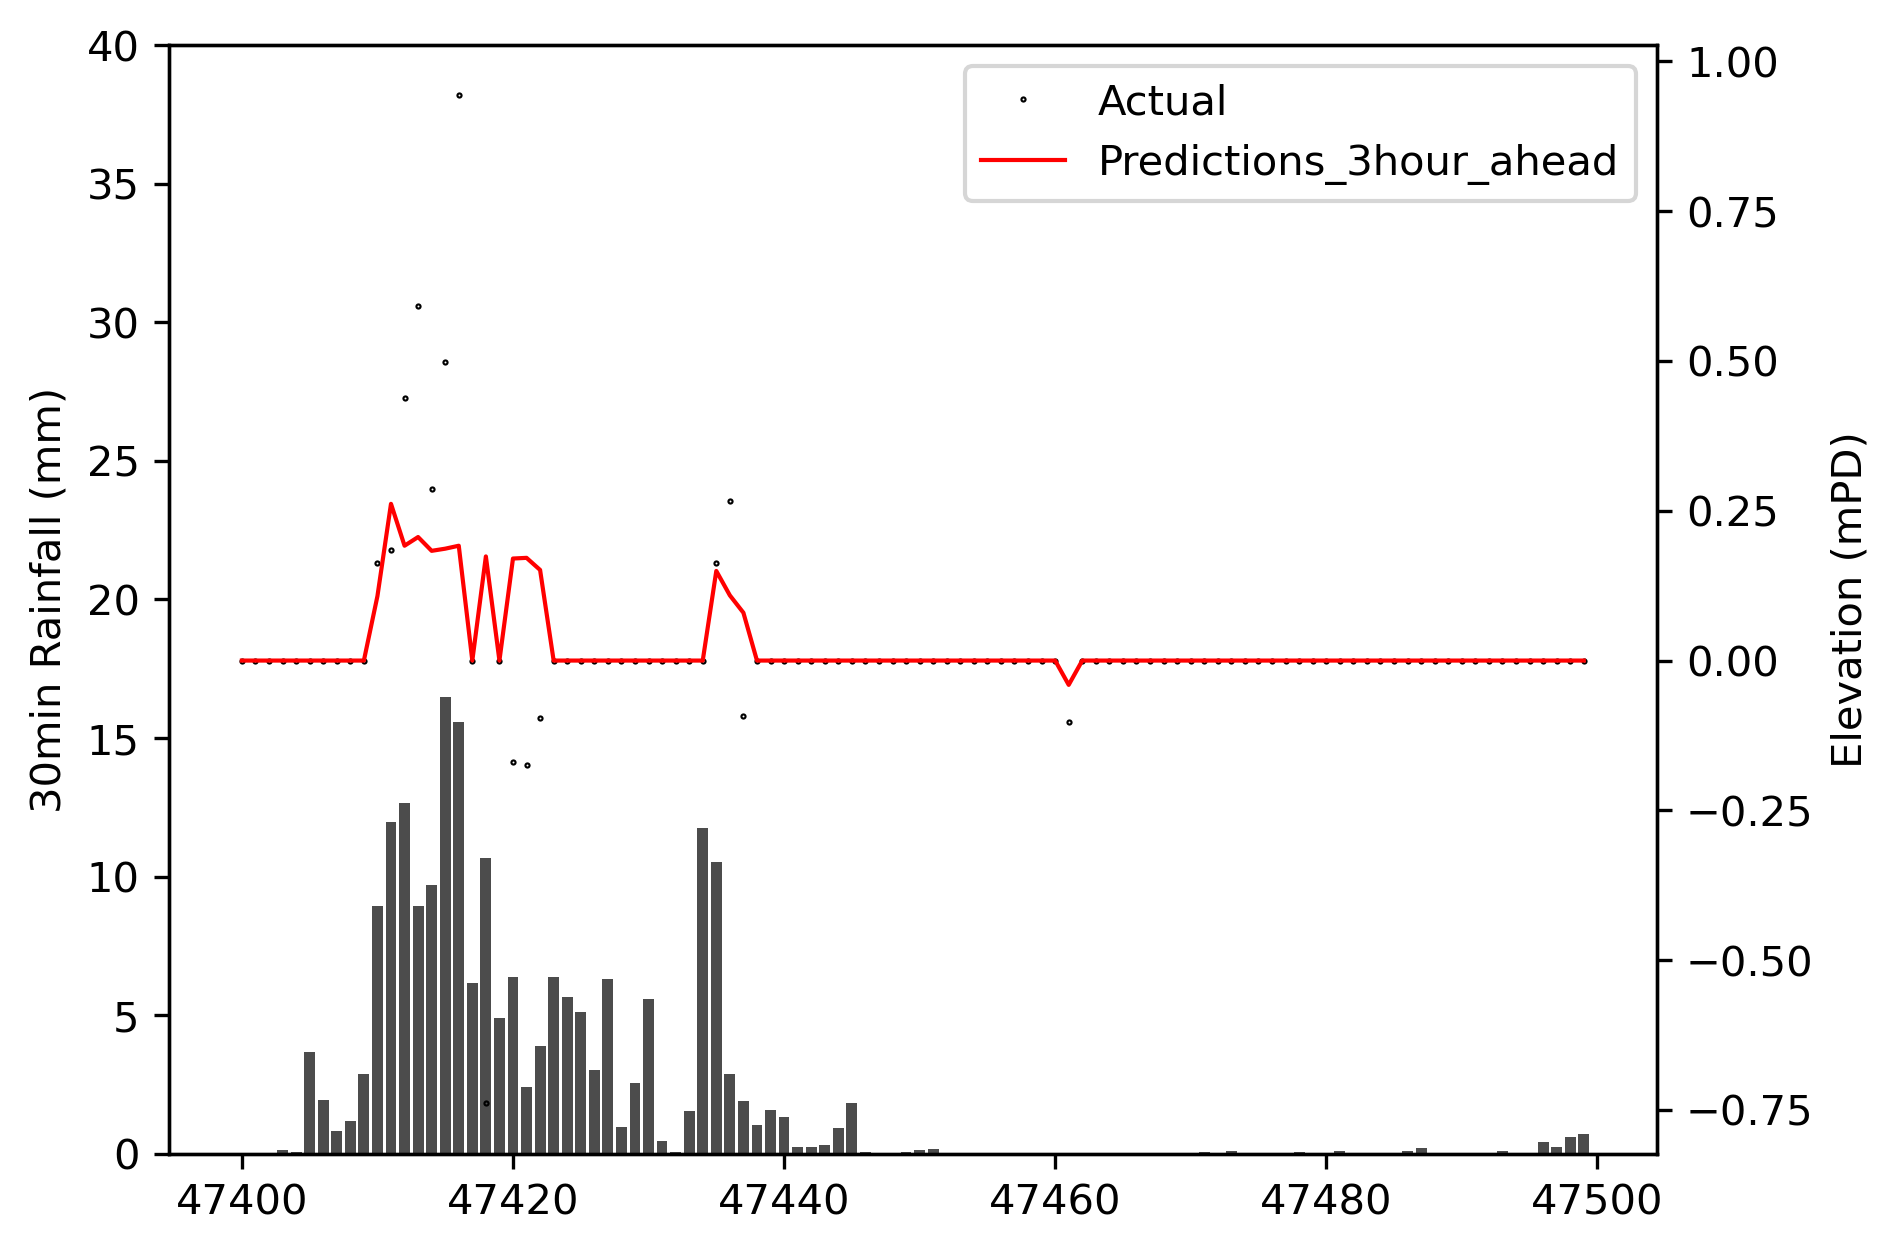

In [124]:
fig, ax1 = plt.subplots(dpi=300)
start, end = 47400, 47500


ax1.bar(range(len(y_train_actual_last_step))[start:end],input_rainfall_features[start+seq_length+step:end+seq_length+step,0]/10,color='k',linewidth=0.5, alpha=0.7)
ax1.set_ylim(0,40)
ax1.set_ylabel("30min Rainfall (mm)")

ax2 = ax1.twinx()
ax2.plot(range(len(y_train_actual_last_step))[start:end],y_train_actual_last_step[start:end],'.', markersize=1, color='k',linewidth=0.1, mfc='none', label='Actual')
# ax2.plot(range(len(naive_predictions))[start:end],naive_predictions[start:end],'-o', markersize=3, color='grey',linewidth=0.3, alpha=0.2, label='Naive Forecast')
ax2.plot(range(len(train_predictions_last_step))[start:end],train_predictions_last_step[start:end],'-', markersize=3, color='r',linewidth=1, label='Predictions_3hour_ahead')

# ax2.set_ylim(-3,2)
# ax2.set_ylim(76,82)
ax2.set_ylabel("Elevation (mPD)")

ax2.legend()
ax2.grid(axis = 'x')